In [1]:
import keras
from src.ParticleNet.EdgeConvLayer import EdgeConvLayer
from src.ParticleNet.GlobalPooling import GlobalAveragePoolingLayer
from utilities import utilities
from ML.ParticleCloud.data_loaders import load_data_top_tagging

#### Loading the Data

In [2]:
X_train, y_train = load_data_top_tagging(top_quark_path="../../../Data/Trainning/t_jets.csv", quark_data_path="../../../Data/Trainning/q_jets.csv", gluon_data_path="../../../Data/Trainning/g_jets.csv")
X_val, y_val = load_data_top_tagging(top_quark_path="../../../Data/Validation/t_jets.csv",quark_data_path="../../../Data/Validation/q_jets.csv", gluon_data_path="../../../Data/Validation/g_jets.csv")

In [3]:
print(f"Size of the Training set: {len(X_train)}")
print(f"Size of the Validation set: {len(X_val)}")

Size of the Training set: 254254
Size of the Validation set: 44869


In [4]:
X_train.shape

(254254, 30, 5)

#### Setting up the NN

In [9]:
# MLP for the first conv layer
mlp_jets = keras.Sequential([
    keras.layers.InputLayer(shape=[8]),
    keras.layers.Dense(32),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(32),
    keras.layers.LeakyReLU()
])


# MLP for the second convolutional layer
jet_tag_model = keras.Sequential([
    keras.layers.InputLayer(shape=(30, 5)),
    EdgeConvLayer(mlp=mlp_jets, mlp_output_dim=32, final_index_coord=2, max_number_particles=30, k_neighbors=4),
    GlobalAveragePoolingLayer(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(rate=0.1),
    keras.layers.Dense(2, activation='softmax')
])

jet_tag_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ edge_conv_layer_2               │ (None, 30, 33)         │         1,344 │
│ (EdgeConvLayer)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer_2  │ (None, 32)             │             0 │
│ (GlobalAveragePoolingLayer)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,586 (14.01 KB)

 Trainable params: 3,586 (14.01 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
jet_tag_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', "auc"])

In [11]:
history = jet_tag_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))   

Epoch 1/50
3973/3973 ━━━━━━━━━━━━━━━━━━━━ 38s 9ms/step - accuracy: 0.8271 - auc: 0.8985 - loss: 0.4016 - val_accuracy: 0.8519 - val_auc: 0.9229 - val_loss: 0.3525
Epoch 2/50
3973/3973 ━━━━━━━━━━━━━━━━━━━━ 36s 9ms/step - accuracy: 0.8522 - auc: 0.9223 - loss: 0.3535 - val_accuracy: 0.8674 - val_auc: 0.9365 - val_loss: 0.3236
Epoch 3/50
3973/3973 ━━━━━━━━━━━━━━━━━━━━ 36s 9ms/step - accuracy: 0.8668 - auc: 0.9345 - loss: 0.3257 - val_accuracy: 0.8744 - val_auc: 0.9419 - val_loss: 0.3086
Epoch 4/50
3973/3973 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - accuracy: 0.8715 - auc: 0.9391 - loss: 0.3141 - val_accuracy: 0.8774 - val_auc: 0.9445 - val_loss: 0.3012
Epoch 5/50
3973/3973 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - accuracy: 0.8725 - auc: 0.9396 - loss: 0.3132 - val_accuracy: 0.8733 - val_auc: 0.9415 - val_loss: 0.3090
Epoch 6/50
3973/3973 ━━━━━━━━━━━━━━━━━━━━ 34s 9ms/step - accuracy: 0.8723 - auc: 0.9403 - loss: 0.3115 - val_accuracy: 0.8778 - val_auc: 0.9457 - val_loss: 0.2979
Epoch 7/50
3973/3973 ━

In [12]:
# perfoming the prediction
y_train_pred = jet_tag_model.predict(X_train)
y_val_pred = jet_tag_model.predict(X_val)

7946/7946 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step
1403/1403 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [13]:
print("Trainnig set:")
utilities.display_metrics(y_true=y_train[:, 0], y_pred=y_train_pred[:, 0] > 0.5)
print("Validation set:")
utilities.display_metrics(y_true=y_val[:, 0], y_pred=y_val_pred[:, 0] > 0.5)

Trainnig set:
Recall: 0.9301
Precision: 0.8530
Confusion Matrix:
[[105076  20613]
 [  8993 119572]]
Validation set:
Recall: 0.9302
Precision: 0.8535
Confusion Matrix:
[[18559  3622]
 [ 1583 21105]]


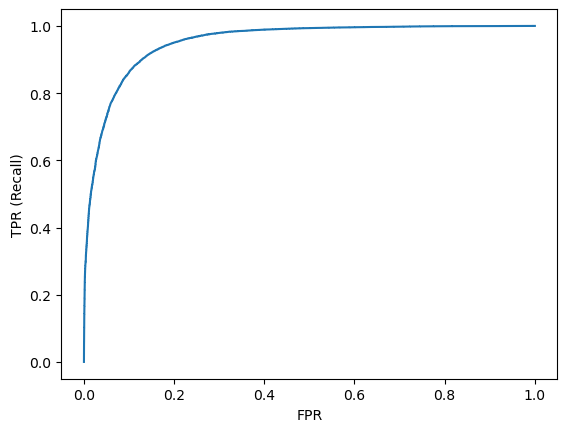

AUC: 0.9527


In [14]:
utilities.display_roc_curve(y_true=y_val[:, 0], y_score=y_val_pred[:, 0])

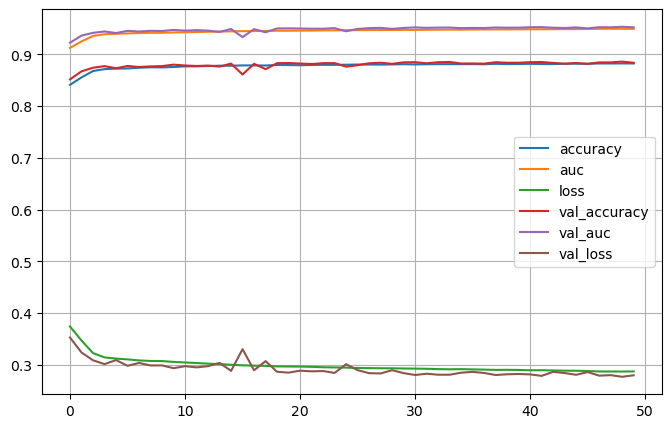

In [15]:
utilities.plot_hist_trainning(history)

In [17]:
utilities.save_model(jet_tag_model, history, "Top_Tagging_ParticleCloud")